In [1]:
from time import time

from keras import Sequential
import numpy as np
import pandas as pd
from keras.layers import Embedding, LSTM, Dense
from keras.preprocessing import sequence

import matplotlib.pyplot as plt


Using TensorFlow backend.


In [2]:
# from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import KFold

In [3]:
# import zipfile
# with zipfile.ZipFile('/home/abhishek_reddy/NLPData.zip', 'r') as zip_ref:
#     zip_ref.extractall('/home/abhishek_reddy/nlpData')

In [4]:
# with zipfile.ZipFile('/home/abhishek_reddy/PoliticalIdeology.zip', 'r') as zip_ref:
#     zip_ref.extractall('/home/abhishek_reddy/nlpData')

In [5]:
MODEL_PATH = '/home/abhishek_reddy/nlpData/PoliticalIdeology/data/binary/word2Vec.model'
modelPath  = '/home/abhishek_reddy/word2Vec.model'
# TRAINING_DATA_PATH = '/home/abhishek_reddy/nlpData/PoliticalIdeology/data/csv/model/train.csv'
# TEST_DATA_PATH = '/home/abhishek_reddy/nlpData/PoliticalIdeology/data/csv/model/test.csv'
# TRAINING_DATA_PATH = '/home/abhishek_reddy/nlpData/PoliticalIdeology/data/csv/model/trainFAKEDATA.csv'
TRAINING_DATA_PATH = '/home/abhishek_reddy/nlpData/NLPData/trainPolitical (1).csv'
TEST_DATA_PATH = '/home/abhishek_reddy/nlpData/NLPData/testPolitical.csv'
# TRAINING_DATA_PATH = '/home/abhishek_reddy/nlpData/PoliticalIdeology/data/csv/model/trainAbortion.csv'
# TEST_DATA_PATH = '/home/abhishek_reddy/nlpData/PoliticalIdeology/data/csv/model/testAbortion.csv'
# TRAINING_DATA_PATH = '/home/abhishek_reddy/nlpData/PoliticalIdeology/data/csv/model/trainModern.csv'
# TEST_DATA_PATH = '/home/abhishek_reddy/nlpData/PoliticalIdeology/data/csv/model/testModern.csv'
DEBATE_DATA_PATH = '/home/abhishek_reddy/nlpData/PoliticalIdeology/data/csv/processed/debate_sentences_part1.csv'
RESULT_PATH = '/home/abhishek_reddy/nlpData/PoliticalIdeology/results/csv/lstmParameters(topic modelling).csv'
RESULT_FINAL_PATH = '/home/abhishek_reddy/nlpData/PoliticalIdeology/results/csv/lstmResults.csv'
# RESULT_DEBATE_FINAL_PATH = '/home/abhishek_reddy/nlpData/PoliticalIdeology/results/csv/lstmDebate.csv'
RESULT_DEBATE_FINAL_PATH = '/home/abhishek_reddy/nlpData/PoliticalIdeology/results/csv/lstmDebate2.csv'
DIFFERENCES_PATH = '/home/abhishek_reddy/nlpData/PoliticalIdeology/results/csv/worstMistakes.csv'
NEW_TWI_RESULTS = '/home/abhishek_reddy/nlpData/PoliticalIdeology/results/csv/twitter(topic modelling).csv'

In [6]:
def saveWord2VecModel(savePath,model):
    model.save(savePath)


def loadWord2VecModel(loadPath):
    return Word2Vec.load(loadPath)


def visualizeWordEmbeddings(wordEmbeddingMatrix, model):
    # Taken from https://machinelearningmastery.com/develop-word-embeddings-python-gensim/
    pca = PCA(n_components=2)
    fittedPCA = pca.fit_transform(wordEmbeddingMatrix)
    pyplot.scatter(fittedPCA[:, 0], fittedPCA[:, 1])
    words = list(model.wv.vocab)
    for i, word in enumerate(words):
        pyplot.annotate(word, xy=(fittedPCA[i, 0], fittedPCA[i, 1]))
    pyplot.show()


def encodeSentences(labelEncoder, sentences):
    return list(map(labelEncoder.transform, sentences))


def mapSentenceToIndex(sentence):
    return [(wordIndex[word] if word in wordIndex else 0) for word in sentence]


def encodeSentences2(sentences, words):
    return list(map(mapSentenceToIndex, sentences))


def splitSentences(sentencesRaw):
    sentences = []
    for sentence in sentencesRaw:
        sentences.append(sentence.split(" "))
    return sentences


def addUniqueWordsToWords(sentencesTrain):
    global maxSentenceLengthActual
    for sentence in sentencesTrain:
        if len(sentence) > maxSentenceLengthActual:
            maxSentenceLengthActual = len(sentence)
        for word in sentence:
            if word not in words:
                words.add(word)


def createWordIndex():
    wordIndex = {}
    for index, word in enumerate(words):
        wordIndex[word] = index
    return wordIndex


def mapToBinary(x):
    if x >= 0:
        return 1
    else:
        return 0

In [7]:
print('')
print('Loading Training Data')
start = time()
dataTrain = pd.read_csv(TRAINING_DATA_PATH)
dataTest = pd.read_csv(TEST_DATA_PATH)
dataDebate = pd.read_csv(DEBATE_DATA_PATH)
totalTime = time() - start
print('Training Data Loaded')
print('Number of Training/Validation sentences: {:d}'.format(len(dataTrain)))
if totalTime > 60:
    print('Took {:f} minutes'.format(totalTime / 60))
else:
    print('Took -- {:f} seconds'.format(totalTime))

print('')
print('Splitting Sentences')
start = time()

sentencesTrainValidateRaw = dataTrain['sentence']
sentencesTestRaw = dataTest['sentence']
sentencesDebateRaw = dataDebate['Sentence']

yTrainValidate = dataTrain['ideology_score'].astype('float')
yTest = dataTest['ideology_score'].astype('float')

sentencesTrainValidate = splitSentences(sentencesTrainValidateRaw)
sentencesTest = splitSentences(sentencesTestRaw)
sentencesDebate = splitSentences(sentencesDebateRaw)


Loading Training Data
Training Data Loaded
Number of Training/Validation sentences: 34973
Took -- 0.770920 seconds

Splitting Sentences


In [8]:
totalTime = time() - start
print('Splitting Sentences Finished')
if totalTime > 60:
    print('Took {:f} minutes'.format(totalTime / 60))
else:
    print('Took -- {:f} seconds'.format(totalTime))

Splitting Sentences Finished
Took -- 0.612802 seconds


In [9]:
words = set()
maxSentenceLengthActual = 0
addUniqueWordsToWords(sentencesTrainValidate)
addUniqueWordsToWords(sentencesTest)
addUniqueWordsToWords(sentencesDebate)
numWords = len(words)

print('')
print('Total Number of Words: {:d}'.format(numWords))
print('Actual Max Sentence Length: {:d}'.format(maxSentenceLengthActual))

print('')
print('Encoding Sentences')
start = time()

wordIndex = createWordIndex()

XTrainValidate = encodeSentences2(sentencesTrainValidate, words)
XTest = encodeSentences2(sentencesTest, words)
XDebate = encodeSentences2(sentencesDebate, words)

XTrainValidate = np.asarray(XTrainValidate)
XTest = np.asarray(XTest)
XDebate = np.asarray(XDebate)

totalTime = time() - start
print('Encoding Sentences Finished')
if totalTime > 60:
    print('Took {:f} minutes'.format(totalTime / 60))
else:
    print('Took -- {:f} seconds'.format(totalTime))


Total Number of Words: 50617
Actual Max Sentence Length: 389

Encoding Sentences
Encoding Sentences Finished
Took -- 0.868292 seconds


In [10]:
# print('')
# print('Making Word2Vec')
# start = time()
# model = Word2Vec(sentencesTrainValidate,
#     size=30,  # Size of representation vector for 1 word
#     min_count=1,  # Minimum frequency for word too count
# )
# total = time() - start
# print('Making Word2Vec Finished')
# if total > 60:
#     print('Took {:f} minutes'.format(total / 60))
# else:
#     print('Took -- {:f} seconds'.format(total))

# print('')
# print('Saving Model')
# #modelPath = 'word2Vec.model'
# saveWord2VecModel(modelPath, model)
# print("Model Saved")


# print('')
# print('Loading Model')
# model = loadWord2VecModel(modelPath)
# print('Model Loaded')
# words = list(model.wv.vocab)

In [11]:
def runBestModel(XTrainValidate, yTrainValidate, XTest, yTest, XDebate):
    embeddingVectorLength = 50
    maxSentenceLength = 200
    lstmLayerSize = 100
    batchSize = 128
    epochs = 3

    XTrainValidate = sequence.pad_sequences(XTrainValidate, maxlen=maxSentenceLength)
    XTest = sequence.pad_sequences(XTest, maxlen=maxSentenceLength)
    XDebate = sequence.pad_sequences(XDebate, maxlen=maxSentenceLength)

    print('')
    print('Training Model')
    start = time()

    model = createLSTMModel(embeddingVectorLength, lstmLayerSize, maxSentenceLength)
    print('')
    print(model.summary())
    model.fit(XTrainValidate, yTrainValidate,
              epochs=epochs,
              batch_size=batchSize,
              verbose=2
              )

    totalTime = time() - start
    print('Training Model Finished')
    if totalTime > 60:
        print('Took {:f} minutes'.format(totalTime / 60))
    else:
        print('Took -- {:f} seconds'.format(totalTime))

    predictionsTrain = model.predict(XTrainValidate, verbose=0)
    predictionsTest = model.predict(XTest, verbose=0)
    predictionsDebate = model.predict(XDebate, verbose=0)
    mseTrain = mean_squared_error(predictionsTrain, yTrainValidate)
    mseTest = mean_squared_error(predictionsTest, yTest)

    print('')
    print('Train MSE: {:f}'.format(mseTrain))
    print('Test MSE: {:f}'.format(mseTest))

    differences = []
    for i in range(len(predictionsTest)):
        predicted = predictionsTest[i][0]
        actual = yTest[i]
        difference = predicted - actual
        differences.append((i, difference, predicted, actual))

    differences.sort(key=lambda x: x[1])

    differencesWorst = []
    for j in range(20):
        index, difference, predicted, actual = differences[j]
        sentenceRaw = dataTrain.loc[index]['sentence_raw']
        sentenceUnclean = dataTrain.loc[index]['sentence_unclean']
        sentence = dataTrain.loc[index]['sentence']
        differencesWorst.append({
            "index": index,
            "difference": difference,
            "sentence1": sentenceRaw,
            "sentence2": sentenceUnclean,
            "sentence3": sentence,
            "predicted": predicted,
            "actual": actual
        })
    for j in range(20):
        index, difference, predicted, actual = differences[len(differences) - j - 1]
        sentenceRaw = dataTrain.loc[index]['sentence_raw']
        sentenceUnclean = dataTrain.loc[index]['sentence_unclean']
        sentence = dataTrain.loc[index]['sentence']
        differencesWorst.append({
            "index": index,
            "difference": difference,
            "sentence1": sentenceRaw,
            "sentence2": sentenceUnclean,
            "sentence3": sentence,
            "predicted": predicted,
            "actual": actual
        })

    differencesDF = pd.DataFrame(differencesWorst)
    differencesDF.to_csv(DIFFERENCES_PATH, index=False)



    predictionsTrainBinary = np.apply_along_axis(mapToBinary, 1, predictionsTrain)
    predictionsTestBinary = np.apply_along_axis(mapToBinary, 1, predictionsTest)
    predictionsDebateBinary = np.apply_along_axis(mapToBinary, 1, predictionsDebate)
    yTrainBinary = yTrainValidate.apply(mapToBinary)
    yTestBinary = yTest.apply(mapToBinary)

    accuracyTrain = accuracy_score(predictionsTrainBinary, yTrainBinary)
    accuracyTest = accuracy_score(predictionsTestBinary, yTestBinary)

    print('')
    print('Train Accuracy: {:f}'.format(accuracyTrain))
    print('Test Accuracy: {:f}'.format(accuracyTest))

    results = {
        'trainMSE': mseTrain,
        'testMSE': mseTest,
        'timeTaken': totalTime,
        'testAccuracy': accuracyTest,
        'trainAccuracy': accuracyTrain,
        'maxSentenceLength': maxSentenceLength,
        'lstmLayerSize': lstmLayerSize,
        'embeddingVectorLength': embeddingVectorLength,
        'batchSize': batchSize,
        'epochs': epochs,
    }
    resultsDF = pd.DataFrame(results, index=[0])
    resultsDF.to_csv(RESULT_FINAL_PATH, index=False)
    print('')
    print('')
    print('Results')
    print(resultsDF)

    debateFinalDF = pd.concat(
        [
            dataDebate,
            pd.DataFrame(predictionsDebate, columns=['prediction']),
            pd.DataFrame(predictionsDebateBinary, columns=['predictionBinary'])
        ],
        axis=1
    )
    debateFinalDF.to_csv(RESULT_DEBATE_FINAL_PATH, index=False)

In [12]:
def findBestParameters(XTrainValidate, yTrainValidate):
    # modelParameters = {
    #     'embeddingVectorLength': [10, 30, 50, 100],
    #     'maxSentenceLength': [100, 300],
    #     'lstmLayerSize': [50, 100, 200],
    #     'batchSize': [32,64,128],
    #     'epochs': [3,5],
    # }

    modelParameters = {
        'embeddingVectorLength': [50],
        'maxSentenceLength': [100, 200, 300],
        'lstmLayerSize': [50, 100, 200],
        'batchSize': [128],
        'epochs': [2],
    }

    results = {}
    kFolds = 3
    kFold = KFold(n_splits=kFolds, shuffle=True, random_state=72)
    for train_index, test_index in kFold.split(XTrainValidate):
        XTrain, XValidate = XTrainValidate[train_index], XTrainValidate[test_index]
        yTrain, yValidate = yTrainValidate[train_index], yTrainValidate[test_index]
        for maxSentenceLength in modelParameters['maxSentenceLength']:
            for lstmLayerSize in modelParameters['lstmLayerSize']:
                for embeddingVectorLength in modelParameters['embeddingVectorLength']:
                    for epochs in modelParameters['epochs']:
                        for batchSize in modelParameters['batchSize']:
                            XTrain = sequence.pad_sequences(XTrain, maxlen=maxSentenceLength)
                            XValidate = sequence.pad_sequences(XValidate, maxlen=maxSentenceLength)

                            print('')
                            print('Training Model')
                            start = time()

                            model = createLSTMModel(embeddingVectorLength, lstmLayerSize, maxSentenceLength)
                            print('')
                            print(model.summary())
                            model.fit(XTrain, yTrain,
                                      validation_data=(XValidate, yValidate),
                                      epochs=epochs,
                                      batch_size=batchSize,
                                      verbose=2
                                      )

                            totalTime = time() - start
                            print('Training Model Finished')
                            if totalTime > 60:
                                print('Took {:f} minutes'.format(totalTime / 60))
                            else:
                                print('Took -- {:f} seconds'.format(totalTime))

                            predictionsTrain = model.predict(XTrain, verbose=0)
                            predictionsValidate = model.predict(XValidate, verbose=0)
                            mseTrain = mean_squared_error(predictionsTrain, yTrain)
                            mseValidate = mean_squared_error(predictionsValidate, yValidate)

                            print('')
                            print('Train MSE: {:f}'.format(mseTrain))
                            print('Validate MSE: {:f}'.format(mseValidate))

                            predictionsTrainBinary = np.apply_along_axis(mapToBinary, 1, predictionsTrain)
                            predictionsValidateBinary = np.apply_along_axis(mapToBinary, 1, predictionsValidate)
                            yTrainBinary = yTrain.apply(mapToBinary)
                            yValidateBinary = yValidate.apply(mapToBinary)

                            accuracyTrain = accuracy_score(predictionsTrainBinary, yTrainBinary)
                            accuracyValidate = accuracy_score(predictionsValidateBinary, yValidateBinary)

                            print('')
                            print('Train Accuracy: {:f}'.format(accuracyTrain))
                            print('Validate Accuracy: {:f}'.format(accuracyValidate))

                            uniqueString = str(embeddingVectorLength) + str(maxSentenceLength) + \
                                           str(lstmLayerSize) + str(batchSize) + str(epochs)
                            if uniqueString in results:
                                results[uniqueString]['testMSE'].append(mseValidate)
                                results[uniqueString]['timeTaken'].append(totalTime)
                            else:
                                results[uniqueString] = {
                                    'testMSE': [mseValidate],
                                    'timeTaken': [totalTime],
                                    'testAccuracy': [accuracyValidate],
                                    'maxSentenceLength': maxSentenceLength,
                                    'lstmLayerSize': lstmLayerSize,
                                    'embeddingVectorLength': embeddingVectorLength,
                                    'batchSize': batchSize,
                                    'epochs': epochs,
                                }
    for uniqueString, result in results.items():
        result['averageTimeTaken'] = np.mean(result['timeTaken'])
        result['medianTimeTaken'] = np.median(result['timeTaken'])
        result['averageTestMSE'] = np.mean(result['testMSE'])
        result['medianTestMSE'] = np.median(result['testMSE'])
        result['averageTestAccuracy'] = np.mean(result['testAccuracy'])
        result['medianTestAccuracy'] = np.median(result['testAccuracy'])
    resultsDF = pd.DataFrame(list(results.values()))
    resultsDF.to_csv(RESULT_PATH, index=False)
    print('')
    print('')
    print('Results')
    print(resultsDF)

In [13]:
def RunModel(XTrainValidate, yTrainValidate):
    # modelParameters = {
    #     'embeddingVectorLength': [10, 30, 50, 100],
    #     'maxSentenceLength': [100, 300],
    #     'lstmLayerSize': [50, 100, 200],
    #     'batchSize': [32,64,128],
    #     'epochs': [3,5],
    # }

   
    embeddingVectorLength = 50
    maxSentenceLength = 100
    lstmLayerSize = 50
    batchSize = 128
    epochs =  2
    

    results = {}
    kFolds = 3
    kFold = KFold(n_splits=kFolds, shuffle=True, random_state=72)
    for train_index, test_index in kFold.split(XTrainValidate):
        XTrain, XValidate = XTrainValidate[train_index], XTrainValidate[test_index]
        yTrain, yValidate = yTrainValidate[train_index], yTrainValidate[test_index]
        XTrain = sequence.pad_sequences(XTrain, maxlen=maxSentenceLength)
        XValidate = sequence.pad_sequences(XValidate, maxlen=maxSentenceLength)
        XTrain = sequence.pad_sequences(XTrain, maxlen=maxSentenceLength)
        XValidate = sequence.pad_sequences(XValidate, maxlen=maxSentenceLength)

        print('')
        print('Training Model')
        start = time()

        model = createLSTMModel(embeddingVectorLength, lstmLayerSize, maxSentenceLength)
        print('')
        print(model.summary())
        model.fit(XTrain, yTrain,
                  validation_data=(XValidate, yValidate),
                  epochs=epochs,
                  batch_size=batchSize,
                  verbose=2
                  )

        totalTime = time() - start
        print('Training Model Finished')
        if totalTime > 60:
            print('Took {:f} minutes'.format(totalTime / 60))
        else:
            print('Took -- {:f} seconds'.format(totalTime))

        predictionsTrain = model.predict(XTrain, verbose=0)
        predictionsValidate = model.predict(XValidate, verbose=0)
        mseTrain = mean_squared_error(predictionsTrain, yTrain)
        mseValidate = mean_squared_error(predictionsValidate, yValidate)

        print('')
        print('Train MSE: {:f}'.format(mseTrain))
        print('Validate MSE: {:f}'.format(mseValidate))

        predictionsTrainBinary = np.apply_along_axis(mapToBinary, 1, predictionsTrain)
        predictionsValidateBinary = np.apply_along_axis(mapToBinary, 1, predictionsValidate)
        yTrainBinary = yTrain.apply(mapToBinary)
        yValidateBinary = yValidate.apply(mapToBinary)

        accuracyTrain = accuracy_score(predictionsTrainBinary, yTrainBinary)
        accuracyValidate = accuracy_score(predictionsValidateBinary, yValidateBinary)

        print('')
        print('Train Accuracy: {:f}'.format(accuracyTrain))
        print('Validate Accuracy: {:f}'.format(accuracyValidate))

        uniqueString = str(embeddingVectorLength) + str(maxSentenceLength) + \
                       str(lstmLayerSize) + str(batchSize) + str(epochs)
        if uniqueString in results:
            results[uniqueString]['testMSE'].append(mseValidate)
            results[uniqueString]['timeTaken'].append(totalTime)
        else:
            results[uniqueString] = {
                'testMSE': [mseValidate],
                'timeTaken': [totalTime],
                'testAccuracy': [accuracyValidate],
                'maxSentenceLength': maxSentenceLength,
                'lstmLayerSize': lstmLayerSize,
                'embeddingVectorLength': embeddingVectorLength,
                'batchSize': batchSize,
                'epochs': epochs,
            }

        
       
    for uniqueString, result in results.items():
        result['averageTimeTaken'] = np.mean(result['timeTaken'])
        result['medianTimeTaken'] = np.median(result['timeTaken'])
        result['averageTestMSE'] = np.mean(result['testMSE'])
        result['medianTestMSE'] = np.median(result['testMSE'])
        result['averageTestAccuracy'] = np.mean(result['testAccuracy'])
        result['medianTestAccuracy'] = np.median(result['testAccuracy'])
    resultsDF = pd.DataFrame(list(results.values()))
    resultsDF.to_csv(NEW_TWI_RESULTS, index=False)
    print('')
    print('')
    print('Results')
    print(resultsDF)
    return model

In [14]:
def createLSTMModel(embeddingVectorLength, lstmLayerSize, maxSentenceLength):
    model = Sequential()
    model.add(Embedding(numWords, embeddingVectorLength, input_length=maxSentenceLength))
    model.add(LSTM(lstmLayerSize))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [15]:
bestModel = RunModel(XTrainValidate, yTrainValidate)


Training Model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           2530850   
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 2,551,101
Trainable params: 2,551,101
Non-trainable params: 0
_________________________________________________________________
None
Train on 23315 samples, validate on 11658 samples
Epoch 1/2
 - 32s - loss: 0.1557 - val_loss: 0.1523
Epoch 2/2
 - 31s - loss: 0.1325 - val_loss: 0.1531
Training Model Finished
Took 1.071205 minutes

Train MSE: 0.103205
Validate MSE: 0.153097

Train Accuracy: 0.774351
Validate Accuracy: 0.586893

Training Model

_____________________________________________________________

In [31]:
#findBestParameters(XTrainValidate, yTrainValidate)
# runBestModel(XTrainValidate, yTrainValidate, XTest, yTest, XDebate)


Training Model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           2530850   
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 2,551,101
Trainable params: 2,551,101
Non-trainable params: 0
_________________________________________________________________
None
Train on 23315 samples, validate on 11658 samples
Epoch 1/2
 - 30s - loss: 0.1560 - val_loss: 0.1525
Epoch 2/2
 - 28s - loss: 0.1326 - val_loss: 0.1543
Training Model Finished
Took 1.012255 minutes

Train MSE: 0.102075
Validate MSE: 0.154298

Train Accuracy: 0.773965
Validate Accuracy: 0.593927

Training Model

_____________________________________________________________

 - 125s - loss: 0.1560 - val_loss: 0.1523
Epoch 2/2
 - 123s - loss: 0.1317 - val_loss: 0.1537
Training Model Finished
Took 4.170537 minutes

Train MSE: 0.102836
Validate MSE: 0.153746

Train Accuracy: 0.775466
Validate Accuracy: 0.590410

Training Model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 300, 50)           2530850   
_________________________________________________________________
lstm_9 (LSTM)                (None, 200)               200800    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 201       
Total params: 2,731,851
Trainable params: 2,731,851
Non-trainable params: 0
_________________________________________________________________
None
Train on 23315 samples, validate on 11658 samples
Epoch 1/2
 - 301s - loss: 0.1562 - val_loss: 0.1530
Epoch 2/2
 - 297s - loss: 0.1335 -

Train on 23315 samples, validate on 11658 samples
Epoch 1/2
 - 77s - loss: 0.1554 - val_loss: 0.1548
Epoch 2/2
 - 74s - loss: 0.1312 - val_loss: 0.1577
Training Model Finished
Took 2.528924 minutes

Train MSE: 0.098594
Validate MSE: 0.157696

Train Accuracy: 0.782501
Validate Accuracy: 0.580031

Training Model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 300, 50)           2530850   
_________________________________________________________________
lstm_17 (LSTM)               (None, 100)               60400     
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 101       
Total params: 2,591,351
Trainable params: 2,591,351
Non-trainable params: 0
_________________________________________________________________
None
Train on 23315 samples, validate on 11658 samples
Epoch 1/2
 - 124s - loss: 0.

Train on 23316 samples, validate on 11657 samples
Epoch 1/2
 - 205s - loss: 0.1562 - val_loss: 0.1520
Epoch 2/2
 - 199s - loss: 0.1316 - val_loss: 0.1585
Training Model Finished
Took 6.756829 minutes

Train MSE: 0.095903
Validate MSE: 0.158451

Train Accuracy: 0.785769
Validate Accuracy: 0.589603

Training Model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, 300, 50)           2530850   
_________________________________________________________________
lstm_25 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 51        
Total params: 2,551,101
Trainable params: 2,551,101
Non-trainable params: 0
_________________________________________________________________
None
Train on 23316 samples, validate on 11657 samples
Epoch 1/2
 - 81s - loss: 0

# Hypothesis Testing 

In [16]:
import tweepy
import sys
import csv
import json
from collections import defaultdict
import pandas as pd
import datetime

In [17]:
#Consumer API keys
consumer_key = 'rfwWcXx9k64ufO8w6VWzUkJMB' # (API key)
consumer_secret = 'tr2FgW095zoQCjJ8Q4lT1npmCxJ6uT5DIji4IpF3asYGq4FeEV' #(API secret key)
#Access token & access token secret #2197666854-
access_token = '2197666854-Ncx5Zb6KmAft9xfQ8vGANEYKAmHofPfItXJUAml' #(Access token)
access_token_secret = 'XvO5WEZDSEYx7IV6lCnmffb7LpbFTbzT2zA3aegp6ohjj' #(Access token secret)

In [18]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

In [11]:
startDate = datetime.datetime(2015,4,12, 0, 0, 0)

endDate =   datetime.datetime(2016, 12, 1, 0, 0, 0)
username = '@HillaryClinton'
tweets_dict = defaultdict(str)
tmpTweets = api.user_timeline(username)
tweets = []
for tweet in tmpTweets:
    if tweet.created_at < endDate and tweet.created_at > startDate:
        tweets.append(tweet)
        
while ((len(tmpTweets)> 0) and (tmpTweets[-1].created_at > startDate)):
    #print(tmpTweets[-1].created_at)
    tmpTweets = api.user_timeline(username, max_id = tmpTweets[-1].id)
    for tweet in tmpTweets:
        if tweet.created_at < endDate and tweet.created_at > startDate:
            tweets_dict[tweet.created_at] = tweet.text

In [ ]:
date_h = []
text_h =[]
for k in tweets_dict:
    date_h.append(k)
    text_h.append(tweets_dict[k])

In [ ]:
Hill = pd.DataFrame(
    {'date': date_h[::-1],
     'tweet': text_h[::-1]
    })

In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *

In [ ]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
stop = stopwords.words('english')
ps = PorterStemmer()

In [ ]:
Hill['tweet'] = Hill['tweet'].apply(lambda row : ' '.join([word  for word in row.split() if word not in (stop)]) )
Hill['tweet'] = Hill['tweet'].apply(lambda row : ' '.join([ps.stem(word)  for word in row.split()]))
Donald['text'] = Donald['text'] .apply(lambda row : ' '.join([word  for word in row.split() if word not in (stop)]) )
Donald['text'] = Donald['text'].apply(lambda row : ' '.join([ps.stem(word)  for word in row.split()]))

In [16]:
Donal = pd.read_csv('DonTrump.csv')
Hillary = pd.read_csv('HillClinton.csv')

In [17]:
Hillary_T = []
for i, row in Hillary.iterrows():
    sentence = row['tweet']
    Hillary_T.append(sentence.split())

In [18]:
Donal_T = []
for i, row in Donal.iterrows():
    sentence = row['text']
    Donal_T.append(sentence.split())

In [22]:
Donald_inp = encodeSentences2(Donal_T, words)
padded_don = sequence.pad_sequences(Donald_inp, maxlen=100)
Don_y = bestModel.predict(padded_don, verbose=0)

In [19]:
Hill_inp = encodeSentences2(Hillary_T, words)
padded_hill = sequence.pad_sequences(Hill_inp, maxlen=100)
Hill_y = bestModel.predict(padded_hill, verbose=0)

In [20]:
Hill_fin =[]
for x in Hill_y:
    Hill_fin.extend(x)

In [23]:
Don_fin =[]
for x in Don_y:
    Don_fin.extend(x)

In [24]:
hill_df= pd.DataFrame({'x': [i for i in range(2406)], 'y': Hill_fin})
don_df = pd.DataFrame({'x': [i for i in range(6714)], 'y': Don_fin})

In [27]:
Hillary.columns = ['ind','date','tweet']

In [30]:
hillar_most_repub = Hillary[Hillary['ind'].isin([1905,2171,1162,21,2363,108,1102,296,1057,1725])]

In [31]:
hillar_most_repub.to_csv('hill_most_repub.csv')

In [33]:
hillar_most_demo = Hillary[Hillary['ind'].isin([1461,2359,373,2193,278,1955,998,785,1237,638])]

In [35]:
hillar_most_demo.to_csv('hillar_most_demo.csv')

In [ ]:
[5457,5749,6195,808,4941,177,5131,4738,5134,5548]

In [38]:
Donal.columns = ['ind','date','tweet']

In [39]:
Donald_most_demo = Donal[Donal['ind'].isin([5457,5749,6195,808,4941,177,5131,4738,5134,5548])]

In [40]:
Donald_most_demo.to_csv('Donald_most_demo.csv')

In [42]:
Donald_most_repub = Donal[Donal['ind'].isin([2567,4995,878,333,5194,6264,936,4264,3942,1484])]

In [44]:
Donald_most_repub.to_csv('Donald_most_repub.csv')

In [41]:
don_df.nlargest(10, 'y')

,x,y
2567,2567,0.510053
4995,4995,0.447960
878,878,0.435699
333,333,0.412392
5194,5194,0.386311
6264,6264,0.383459
936,936,0.381921
4264,4264,0.376332
3942,3942,0.376318
1484,1484,0.360066


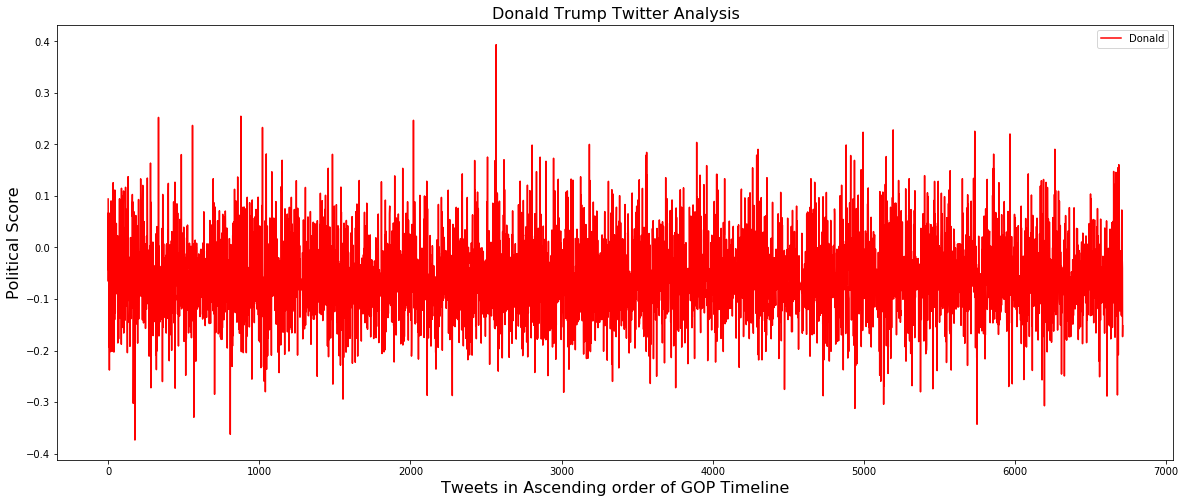

In [33]:
plt.figure(figsize=(20,8))
plt.xlabel('Tweets in Ascending order of GOP Timeline', fontsize=16)
plt.ylabel('Political Score', fontsize=16)
plt.title('Donald Trump Twitter Analysis', fontsize=16)
plt.plot(don_df['x'], don_df['y'], label='Donald', color ='r')
plt.legend()
plt.show()

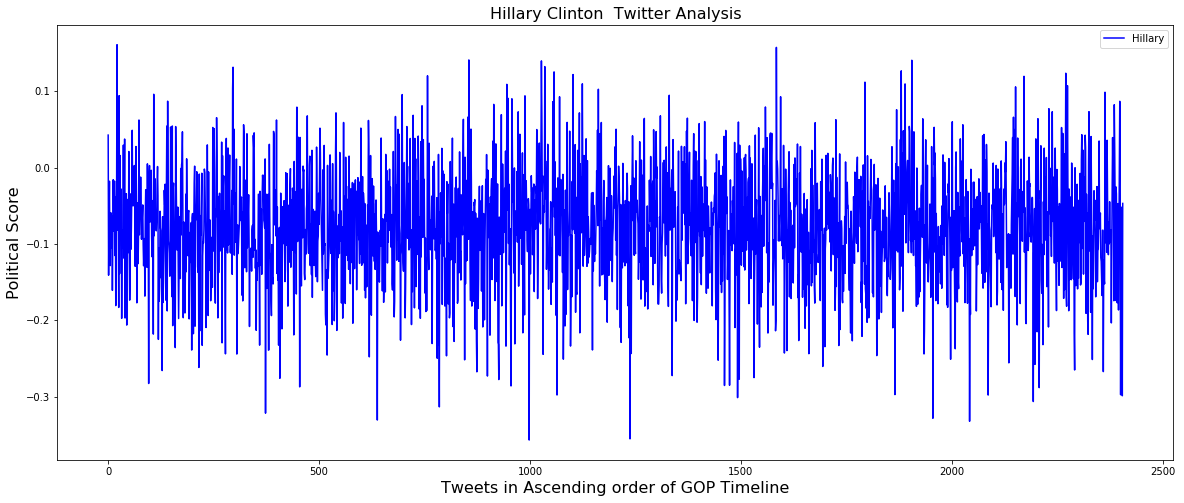

In [34]:
plt.figure(figsize=(20,8))
plt.xlabel('Tweets in Ascending order of GOP Timeline', fontsize=16)
plt.ylabel('Political Score', fontsize=16)
plt.title('Hillary Clinton  Twitter Analysis', fontsize=16)
plt.plot(hill_df['x'], hill_df['y'], label='Hillary',color ='b')
plt.legend()
plt.show()

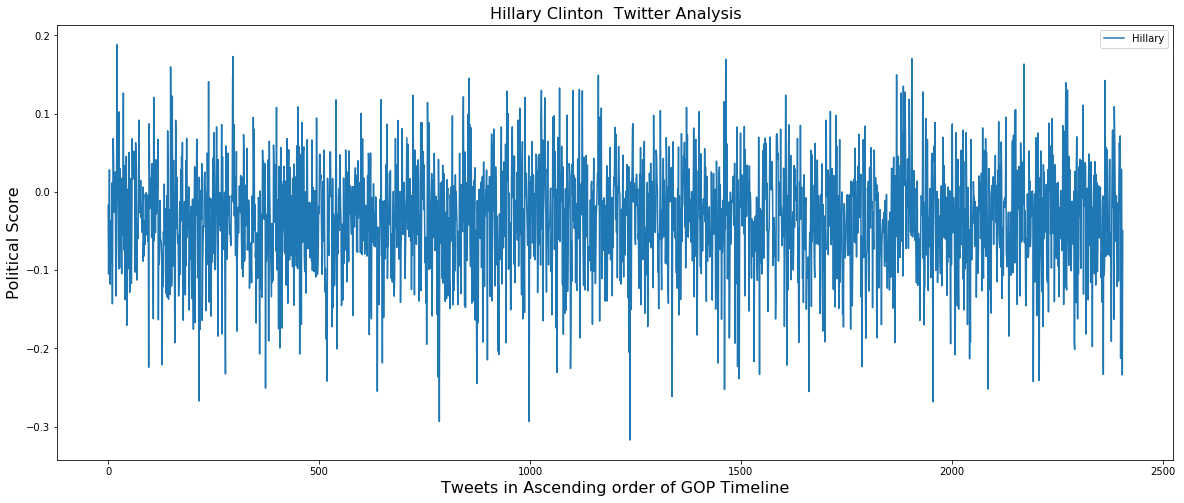

In [86]:
plt.figure(figsize=(20,8))
plt.xlabel('Tweets in Ascending order of GOP Timeline', fontsize=16)
plt.ylabel('Political Score', fontsize=16)
plt.title('Hillary Clinton  Twitter Analysis', fontsize=16)
plt.plot(hill_df['x'], hill_df['y'], label='Hillary',color = 'b')
#plt.plot(ks_test['key'], ks_test['curr_cdf'], label='Empirical CDF')
plt.legend()
plt.show()

# Input Test

In [28]:
sentence = "I don’t care who marries whom. The government should not be in the business of legislating marriage. Get out of our lives."

In [25]:
# sentence = 'More Jobs, Bigger Paychecks, and Fairer Taxes'

In [29]:
sent = sentence.split('.')
inp = []
for se in sent:
    res = se.split()
    inp.append(res)

In [30]:
encode = encodeSentences2(inp, words)
padded = sequence.pad_sequences(encode, maxlen=100)
Y = bestModel.predict(padded, verbose=0)
print(Y)

[[ 0.02926761]
 [-0.03981771]
 [ 0.01265274]
 [ 0.07202496]]


In [150]:
 inp = encodeSentences2(sentence, words)

In [151]:
pad_inp = sequence.pad_sequences(inp, maxlen=100)

In [152]:
y = bestModel.predict(pad_inp, verbose=0)

In [153]:
print(y)

[[-0.08903411]]
